In [1]:
%matplotlib widget
from typing import Callable
from dataclasses import dataclass

We first load the prerequisite linear algebra and plotting libraries

In [2]:
import numpy as np
import sympy as sympy  # a compute algebra system in python
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

# Monte Carlo Sampling

Monte Carlo sampling is tasked with evaluating expectations. Consider a probability triple $(\Omega, \mathcal{F}, P)$, and let $X:\Omega \to \mathbb{R}$ be a random variable. Let $Y = g(X)$ be another random variable, for a function $g:\mathbb{R} \to \mathbb{R}$. Monte Carlo sampling computes $\mathbb{E}\left[X\right]$ and $\mathbb{E}\left[Y\right] = \mathbb{E}\left[g(X)\right]$ by using _unstructured samples_ distributed according to $X$. The algorithm has three steps

1. Generate $n$ independent samples: $x^{(1)}, x^{(2)}, \ldots, x^{(n)}$
2. Evaluate $g$: $y^{(i)} = g(x^{(i)})$ for $i = 1,\ldots, n$
3. Compute the arithmetic average $\hat{\mu} = \frac{1}{n} \sum_{i=1}^n y^{(i)}$

The final arithmetic average is approximately correct $\mu \approx \mathbb{E}\left[g(X)\right]$, and the accuracy increases as the number of samples increases. This algorithm works (with various effectiveness) for arbitrary $X$ and arbitrary $g$. The required capabilities are to be able to **sample according to $X$ and to evaluate $g$**

So lets create a Monte Carlo sampling code that can be used for any problem.

In [3]:
@dataclass
class MonteCarloEstimate:
    estimate: np.ndarray
    samples: np.ndarray
    evaluations: np.ndarray

def monte_carlo(num_samples: int,
                sample_generator: Callable[[int], np.ndarray],
                g_evaluator: Callable[[np.ndarray], np.ndarray],
                cumsum: bool = False):
    """Perform Monte Carlo sampling.

    Inputs
    ------
    num_samples: number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: a function that takes as inputs the samples and outputs the evaluations.
                 The outputs can be any dimension, however the first dimension should have size *num_samples*
    cumsum: An option to return estimators of all sample sizes up to num_samples

    Returns
    -------
    A Monte Carlo estimator of the mean, samples, and evaluations
    """
    samples = sample_generator(num_samples)
    evaluations = g_evaluator(samples)
    if cumsum is False:
        estimate =  np.sum(evaluations, axis=0) / float(num_samples)
    else:
        estimate = np.cumsum(evaluations, axis=0) / np.arange(1, num_samples + 1, dtype=np.float64)

    return MonteCarloEstimate(estimate, samples, evaluations)

Thats it! Such a small function, such greater power.

In [4]:
def test() -> None:

    num_samples_test = 50

    # for reproducible results to both calls to monte carlo
    samples = np.random.rand(num_samples_test)
    def sampler_test(n: int) -> np.ndarray:
        return samples

    # Generally can use any sample
    # sampler_test = lambda n: np.random.rand(n)
    def func_test(x):
        return np.sin(x)

    mc = monte_carlo(num_samples_test, sampler_test, func_test)
    print("estimate_test = ", mc.estimate)
    mc = monte_carlo(num_samples_test, sampler_test, func_test, cumsum=True)
    print("estimate_test = ", mc.estimate)
    true_value = -np.cos(1) + np.cos(0)
    print("True value: ", true_value)

test()

estimate_test =  0.4622456747832691
estimate_test =  [0.13924359 0.11579465 0.23197994 0.19449108 0.32035888 0.29217875
 0.35515756 0.35485301 0.40589099 0.38085477 0.36898511 0.35759893
 0.39042678 0.41224125 0.41181284 0.38749404 0.41144864 0.41437383
 0.39789849 0.40981112 0.42046265 0.42276504 0.42470303 0.43355936
 0.44298932 0.45346751 0.46014206 0.4481662  0.4410523  0.43077743
 0.44073987 0.43035083 0.43593246 0.44067282 0.43847443 0.43654853
 0.44354998 0.45289787 0.44486627 0.45068733 0.44567452 0.4538733
 0.45309169 0.45563308 0.45957564 0.45323996 0.45924702 0.46621215
 0.46168252 0.46224567]
True value:  0.45969769413186023


Using cumsum is equivalent to the following

\begin{equation}
\frac{1}{n}\sum_{i=1}^n y^{(i)} = \frac{(n-1)  \frac{1}{n-1}\sum_{i=1}^{n-1} y^{(i)} + y^{(n)}}{n}
\end{equation}

## Interim analytical examples

\begin{equation}
\int_{0}^3 \int_{0}^2 \sin(x + y) dx dy
\end{equation}

We want to rewrite this as an integral with respect to a probability density $\int g(x,y) f_{XY}(x,y) dxdy.$

Note that the random variable $(X,Y) \sim U([0,2] \times [0,3])$ has probability density $f_{XY}(x,y) = 1/6.$ 

\begin{equation}
\int_{0}^3 \int_{0}^2 \sin(x + y) dx dy = 6 \int_{0}^3 \int_{0}^2 \sin(x + y) \frac{1}{6} dx dy = 6 \mathbb{E}\left[\sin(X + Y)\right]
\end{equation}


This was for a continuous random variable. However, recall that there are two cases for expected value: $\mathbb{E}\left[X\right]$

1. For continuous random variables: $\mathbb{E}\left[X\right] = \int x f_{X}(x) dx$
2. For discrete ranom variables:

\begin{equation}
\mathbb{E}\left[X\right] = \sum_{i=1}^N a_i P_X(X = a_i)
\end{equation}

Discrete RV Example: Suppose you are flipping a coin. Let heads be associated with $H=1$, and let tails be associated with $H=0.$ Suppose $P(H=1) = 0.8$ so that $P(H=0) = 0.2$ What is the expected value for the coin??
\begin{equation}
\mathbb{E}\left[C\right] = (1) * 0.8 + (0) * 0.2 = 0.8
\end{equation}

## Example: the integration connection

Let us integrate the function
\begin{equation}
\int_{\mathbb{R}} x^2\exp\left( - x^2 / 2\right) dx,
\end{equation}
with the integration domain being the real numbers $\mathbb{R}$. First lets compute the analytic solution

In [5]:
xanalytic = sympy.symbols('x')
int_analytic = sympy.integrate(xanalytic**2 * sympy.exp(-xanalytic**2 / 2), (xanalytic, -sympy.oo, sympy.oo))
int_numeric = np.float64(sympy.N(int_analytic))
print("Analytic solution = {0}, numeric representation = {1}".format(int_analytic, int_numeric))

Analytic solution = sqrt(2)*sqrt(pi), numeric representation = 2.5066282746310007


To use Monte Carlo we need to rewrite the integral as an expectation. There are many ways to do this, but here we notice that there is a very close connection to Gaussians. In particular, we can rewrite the integral as

\begin{align}
\int_X x^2 \exp(-x^2/2) dx = \sqrt{2\pi} \int_X x^2 \frac{\exp(-x^2/2)}{\sqrt{2\pi}} dx = \sqrt{2\pi}\mathbb{E}\left[X^2\right],
\end{align}
where $X \sim \mathcal{N}(0,1).$ We now have an expectation and so we can use Monte Carlo to evaluate it.

In [6]:
sampler = np.random.randn  # Gaussian sampler
# sampler = np.random.rand
# sampler = np.random.gamma
def g(x: np.ndarray) -> np.ndarray:
    return x**2
nsamples = 100000
mc = monte_carlo(nsamples, sampler, g)  # quadratic function
print("Estimated integral value = {0}".format(mc.estimate * np.sqrt(2.0 * np.pi)))

Estimated integral value = 2.4907092444582073


Lets take a look at the histogram of the input samples and the evaluations

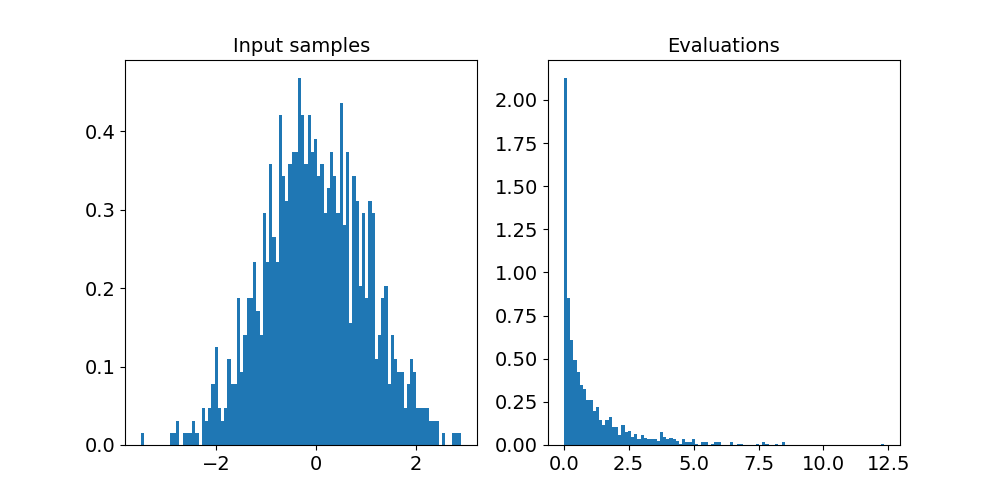

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(mc.samples, bins=100, density=True)
axs[0].set_title("Input samples", fontsize=14)
axs[1].hist(mc.evaluations, bins=100, density=True)
axs[1].set_title("Evaluations", fontsize=14)
plt.show()

The output of the Monte Carlo algorithm is actually a *sample of another random variable.* In fact, we can run Monte Carlo multiple times and get a different result every time.

Trial 0: estimated integral 2.493994329383953
Trial 1000: estimated integral 2.5026728962723674
Trial 2000: estimated integral 2.5156961336866916
Trial 3000: estimated integral 2.501533513636981
Trial 4000: estimated integral 2.492391144195828
Trial 5000: estimated integral 2.501309333723736
Trial 6000: estimated integral 2.5042152895522696
Trial 7000: estimated integral 2.5036811961431806
Trial 8000: estimated integral 2.5082764471382264
Trial 9000: estimated integral 2.5098640914268597


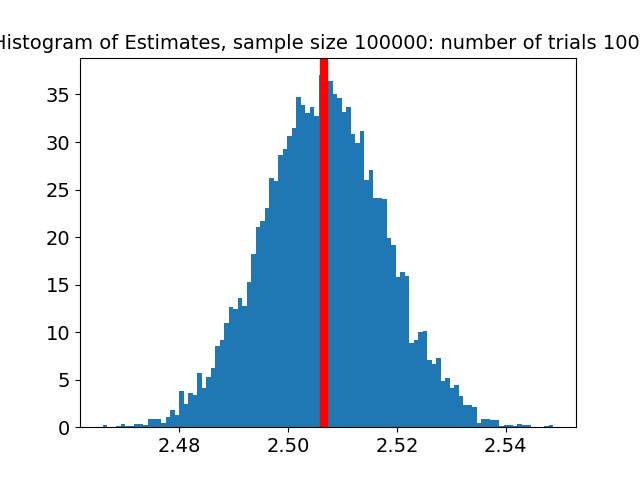

In [8]:
nsamples = 100000
ntrials = 10000
estimates = np.zeros((ntrials))

for ii in range(ntrials):
    mc = monte_carlo(nsamples, sampler, g)
    estimates[ii] = mc.estimate * np.sqrt(2.0 * np.pi)
    if ii % 1000 == 0:
        print("Trial {0}: estimated integral {1}".format(ii, estimates[ii]))

fig, axs = plt.subplots(1)
axs.hist(estimates, bins=100, density=True)
axs.axvline(x=int_numeric, linewidth=6, color='red')
axs.set_title(f"Histogram of Estimates, sample size {nsamples}: number of trials {ntrials}", fontsize=14)
plt.show()

What random variable is this? It kind of looks like a Gaussian.... weird?! We will study to determine what is happening. Key takeaway **A single result of the Monte Carlo algorithm is RANDOM, it can be viewed as a single sample from some other random variable. It is very important to understand teh properties of this other random variable**

Lets plot a histogram of the errors to get a better understanding.

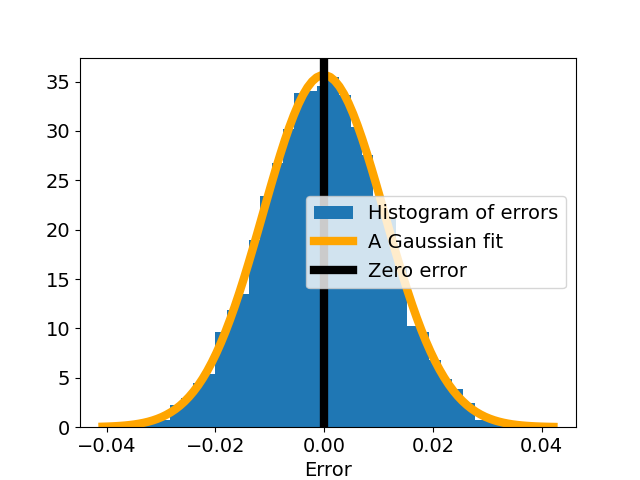

In [9]:
errs = estimates - int_numeric
mean = np.mean(errs)  # sample mean
v = np.var(errs)  # sample variance
plt.figure()
plt.hist(errs, bins=40, density=True, label="Histogram of errors")
x = np.linspace(min(errs), max(errs), 100)
plt.plot(x, 1.0/np.sqrt(2*np.pi * v) * np.exp(-0.5 * (x - mean)**2 / v), color='orange', linewidth=6, label="A Gaussian fit")
plt.axvline(x=0, linewidth=6, color='black', label="Zero error")
plt.xlabel("Error")
plt.legend()
plt.show()

The histogram of errors looks to be almost like a Gaussian. 

### Convergence with the number of samples

We can now low at the behavior of this algorithm as we change the number of samples. For this, we use the `cumsum` functionality that we added to the Monte Carlo algorithm. Recall that if we set this flag to true, the algorithm returns a set of $n$ estimators (instead of 1). Each estimator corresponds to using a certain amount of samples.

In [10]:
# Compute a hierarchy of estimates using shared samples from 1 to 100000
mc = monte_carlo(100000, sampler, g, cumsum=True)
estimate = mc.estimate * np.sqrt(2 * np.pi)  # add the required scaling

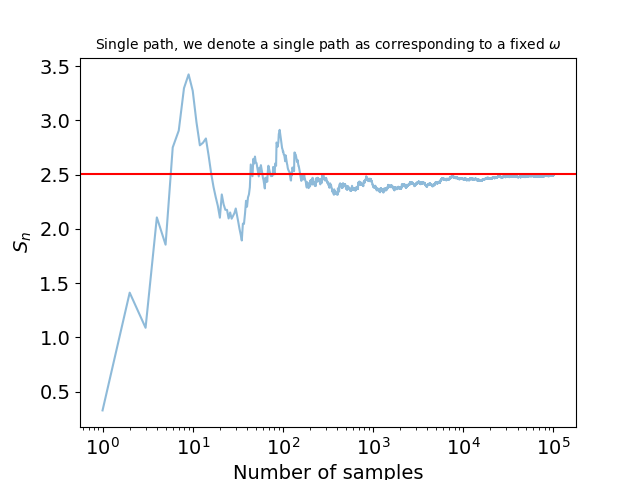

In [11]:
plt.figure()
nsamples_arr = 1 + np.arange(estimate.shape[0])  # an array of numbers from 1....nsamples
plt.semilogx(nsamples_arr, estimate, alpha=0.5)
plt.axhline(y=int_numeric, color='red', label='True value')
plt.xlabel('Number of samples', fontsize=14)
plt.ylabel(r'$S_n$', fontsize=14)
plt.title(r'Single path, we denote a single path as corresponding to a fixed $\omega$', fontsize=10)
plt.show()

The average bounces around a little bit, but it eventually converges. We can repeat this experiment over many trials and plot the paths. **View this a single path denoted by some $\omega$, this is the function $S_n(\omega)$**

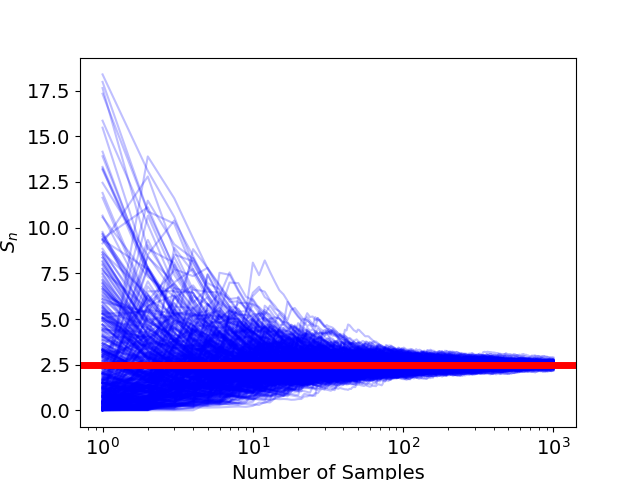

In [12]:
ntrials = 500
nsamples = 1000
estimate_vals = np.zeros((ntrials, nsamples))
plt.figure()
for ii in range(ntrials):
    mc = monte_carlo(nsamples, sampler, g, cumsum=True)
    estimate_vals[ii, :] = mc.estimate * np.sqrt(2 * np.pi)  # add the required scaling
    plt.semilogx(np.arange(1, nsamples+1), estimate_vals[ii, :], '-', color='blue', alpha=0.25)
plt.axhline(y=int_numeric, color='red', linewidth=5)
plt.xlabel('Number of Samples')
plt.ylabel(r'$S_n$')
plt.show()

Lets look at some slices of the above graph. We will fix $n$ at a couple values, and then look at the distribution of $S_n$.

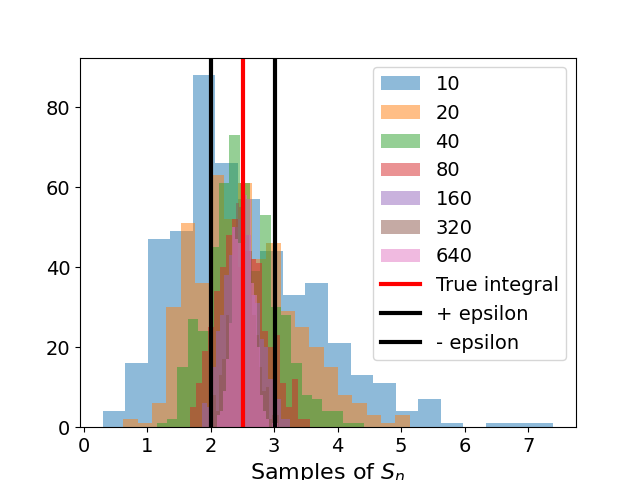

In [13]:
fixed_n = [10, 20, 40, 80, 160, 320, 640]  # Sample set sizes we are investigating
plt.figure()
for n in fixed_n:
    plt.hist(estimate_vals[:, n], bins=20, alpha=0.5, label="{0}".format(n))
plt.axvline(x=int_numeric, color='red', linewidth=3, label='True integral')
plt.axvline(x=int_numeric + 0.5, color='black', linewidth=3, label='+ epsilon')
plt.axvline(x=int_numeric - 0.5, color='black', linewidth=3, label='- epsilon')

plt.xlabel(r'Samples of $S_n$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

We see that for low numbers of samples, we have big blobs, but quickly the histograms converge to things that look Gaussian. For all examples, the average of the histogram appears to be around the truth. The width of the histogram shrinks with data. Lets take a look at how fast this width shrinks. The way that we measure "width" is through the variance (or standard deviation).

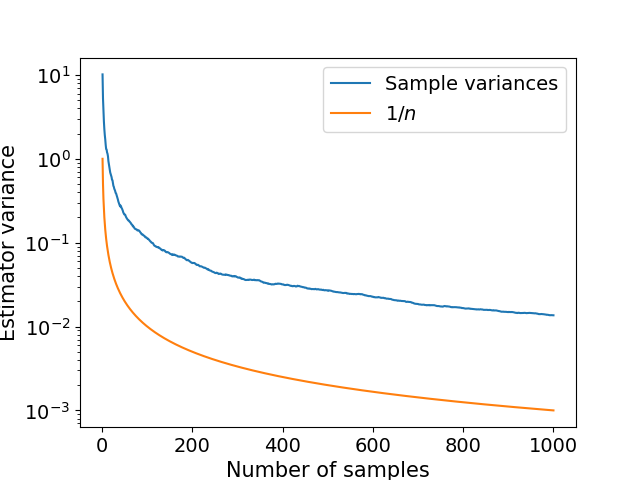

In [14]:
plt.figure()
variances = np.var(estimate_vals, axis=0)  # variance of the histogram at each $n$
plt.semilogy(np.arange(1, variances.shape[0]+1), variances, label='Sample variances')
plt.semilogy(np.arange(1, variances.shape[0]+1), 1/(np.arange(1, variances.shape[0]+1)), label=r'$1/n$')
plt.ylabel('Estimator variance', fontsize=15)
plt.xlabel('Number of samples', fontsize=15)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We see the expected rate of convergence is $1/n$. 
Analytically, this can be shown as follows
\begin{equation}
var(\frac{1}{n} \sum_{i=1}^n X_i) = \frac{1}{n^2} var(\sum_{i=1}^n X_i) = \frac{1}{n^2} \sum_{i=1}^n var(X_i) = \frac{1}{n^2} \sum_{i=1}^n \sigma^2 = \frac{n}{n^2} \sigma^2 = \frac{\sigma^2}{n}
\end{equation}

Standard deviations have the same units as the expectations, and so they make more sense as a measure of error (width of the histograms)

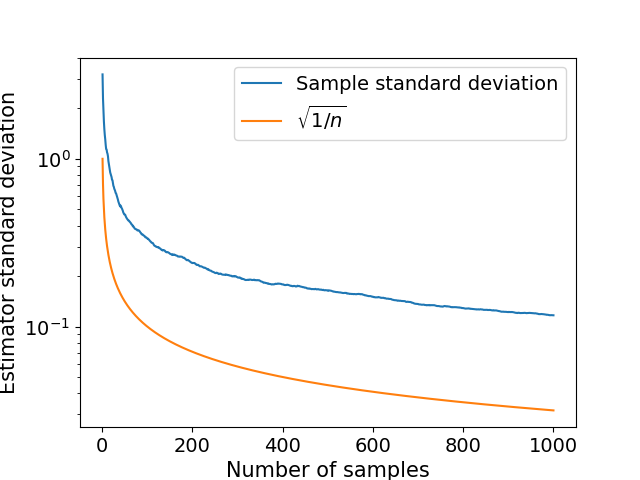

In [15]:
plt.figure()
variances = np.var(estimate_vals, axis=0)  # variance of the histogram at each $n$
plt.semilogy(np.arange(1, variances.shape[0]+1), np.sqrt(variances), label='Sample standard deviation')
plt.semilogy(np.arange(1, variances.shape[0]+1), np.sqrt(1/(np.arange(1, variances.shape[0]+1))), label=r'$\sqrt{1/n}$')
plt.ylabel('Estimator standard deviation', fontsize=15)
plt.xlabel('Number of samples', fontsize=15)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Now we see the drawback of Monte Carlo samples, this rate of convergence is very very slow! Nothing is ever free.....

## Convergence

### Strong Law of Large Numbers (Almost sure convergence)

Let $X_1,X_2,\ldots$ be a sequence of i.i.d. random variables, eaching having finite mean $\mu$. Then
\begin{equation}
P\left(\lim_{n\to \infty} \frac{1}{n}\left(X_1 + X_2 + \ldots + X_n\right) = \mu\right) = 1.
\end{equation}
In words, the partial averages 
\begin{equation}
\frac{1}{n}\left(X_1 + X_2 + \ldots + X_n\right)
\end{equation}
converge *almost surely* to $\mu$.

### Weak Law of Large Numbers (Convergence in probability)

Let $X_1,X_2,\ldots$ be a sequence of i.i.d. random variables, eaching having finite mean $\mu.$ Then for all $\epsilon > 0$
\begin{equation}
\lim_{n \to \infty} P\left( \left \lvert \frac{1}{n}\left(X_1 + X_2 + \ldots + X_n\right) - \mu \right \rvert \geq \epsilon\right) = 0.
\end{equation}
In words, the partial averages 
\begin{equation}
\frac{1}{n}\left(X_1 + X_2 + \ldots + X_n\right)
\end{equation}
converge *in probability* to $\mu$.


\begin{equation}
P_X \left( \left(\frac{X - \mu}{\alpha}\right)^2 > 1\right) = P_X \left( \frac{|X - \mu|}{|\alpha|} > 1\right) = P_X \left( |X - \mu| > \alpha\right)
\end{equation}

### Central Limit Theorem (Convergence in distribution)

Let $X_1,X_2,\ldots$ be a sequence of i.i.d. with finite mean $\mu$ and finite variance $\sigma^2$.
Let the random variables $S_n$ denote the partial sums
\begin{equation}
S_n = \frac{1}{n} \sum_{i=1}^n X_i,
\end{equation}
and let $Y_n$ be a shifted and scaled version of this random variable
\begin{equation}
Y_n = \frac{nS_{n} - n \mu}{\sigma \sqrt{n}} = \sqrt{n}\frac{S_{n} - \mu}{\sigma}
\end{equation}
then $Y_n$ converges to a standard normal $\mathcal{N}(0, 1)$ in distribution. Recall the standard normal has density
\begin{equation}
f_X(x) = \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}x^2\right).
\end{equation}
Equivalently we can write
\begin{equation}
\frac{S_{n} - \mu}{\sigma} \to \mathcal{N}\left(0, \frac{1}{n}\right),
\end{equation}
which denotes convergence in distribution to a Gaussian random variable with mean $0$, and variance $\frac{1}{n}$. Yet another statement we can write is that
\begin{equation}
S_{n} \to \mathcal{N}\left(\mu, \frac{\sigma^2}{n}\right)
\end{equation}
which provides the explanation for the Gaussian distributions that we saw above.

## Usage of the CLT for error analysis: an introduction to confidence intervals

Next time!